<a href="https://colab.research.google.com/github/whispermy/novatus_academia/blob/main/Week8_Lab5_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

알림: 이 코드는 TensorFlow 2.5.0을 사용합니다. 필요시에는 아래의 라인의 comment를 제거하고 실행해주세요.

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


앞에서 배운것처럼, 학습을 위한 시계열 데이터를 만들겠습니다.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

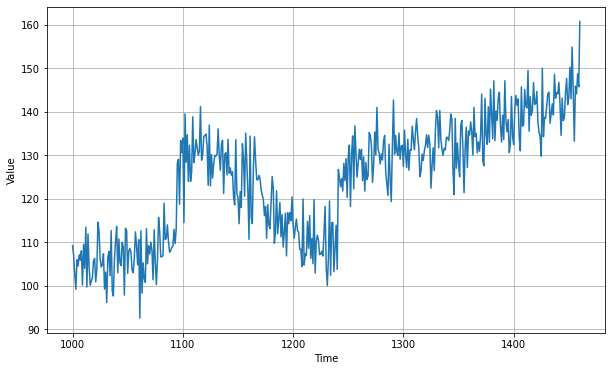

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

이제 3개의 레이어 (2개의 hidden 레이어 및 하나의 출력 레이어)를 가진 심층 신경망을 학습하겠습니다.

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


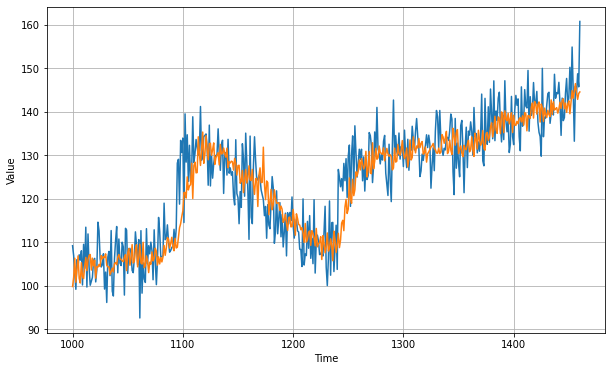

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.836214

 Learning rate을 tuning 해 보겠습니다

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

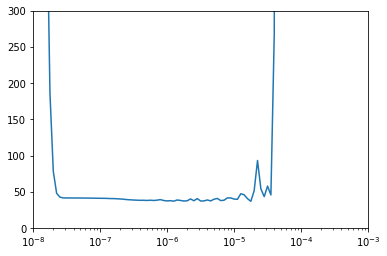

In [ ]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

위의 결과에서, 8e-6 이 learning rate으로 좋을 것 같습니다. 다시 학습해 보겠습니다.

In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

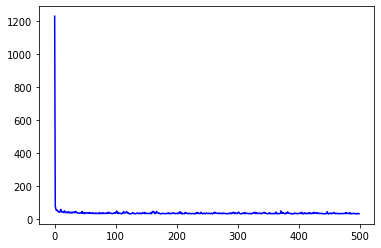

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

여기서 첫 epoch에서 loss 값이 크기 때문에 대부분의 epoch들이 필요없는 것처럼 보입니다. 그러나 처음에 loss 값이 크기 때문에 scale의 차이 때문일 수 있습니다. 첫 10 epoch을 제외하고 봅시다.

[59.62078094482422, 43.252262115478516, 46.771034240722656, 45.64096450805664, 42.924888610839844, 40.24184036254883, 51.15299987792969, 45.785884857177734, 40.72090148925781, 39.94826889038086, 44.65400695800781, 39.778079986572266, 40.52849578857422, 46.10111999511719, 37.787559509277344, 38.63316345214844, 39.93830871582031, 43.59283447265625, 37.56395721435547, 37.57981872558594, 43.614410400390625, 42.8819694519043, 42.8733024597168, 38.614776611328125, 47.396995544433594, 43.33192825317383, 43.10613250732422, 38.76961898803711, 36.92448425292969, 38.35824966430664, 36.57472229003906, 36.88003921508789, 39.01299285888672, 39.016265869140625, 37.15348815917969, 47.6069450378418, 36.423179626464844, 37.91155242919922, 34.94060134887695, 41.09113311767578, 35.31951141357422, 35.23310470581055, 38.897193908691406, 39.17752456665039, 38.18535232543945, 35.538570404052734, 38.96806716918945, 36.98505401611328, 40.77610397338867, 35.738555908203125, 35.64273452758789, 37.82222366333008, 

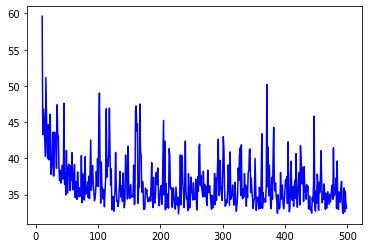

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

처음 10 epoch 이후에도 학습이 이루어지고 있는 것을 볼 수 있습니다.

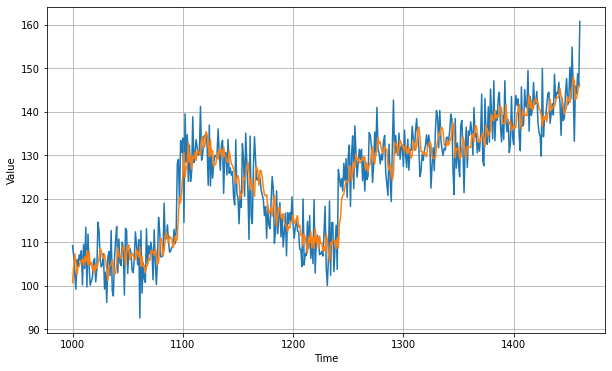

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.562574

위에서 보듯, 하나의 레이어를 쓴 신경망보다 성능을 향상할 수 있습니다.